# Examples
In this Notebook, we provide a few examples comparing the several optimization methods.\
We organize the Notebook as follows:
* First, we visualize the type of data and the graphs we consider:
    * Display examples of local data for the binary classification task.
    * Display examples of local data for the Linear Regression task.
    * Display of the several fixed topology graphs we studied.
    * Display of the random geometric graphs used for the time-varying setting, with 2 different values of parameter $\chi$.
* Then, we compare the 4 optimizers we support ([MSDA](https://arxiv.org/pdf/1702.08704.pdf), [ADOM+](https://openreview.net/attachment?id=L8-54wkift&name=supplementary_material), [Continuized](https://arxiv.org/pdf/2106.07644.pdf), [DADAO](https://hal.archives-ouvertes.fr/hal-03737694/document)).

## Visualization of the type of data and graphs considered

In [1]:
from data import create_data
from visualization import plot_3_classif, plot_3_reg, plot_all_fixed_graphs, plot_2_time_varying_graph_sequence

In [2]:
# Variables for the problem
n_workers=3
n_samples=n_workers*100

### Data 1: Binary Classification

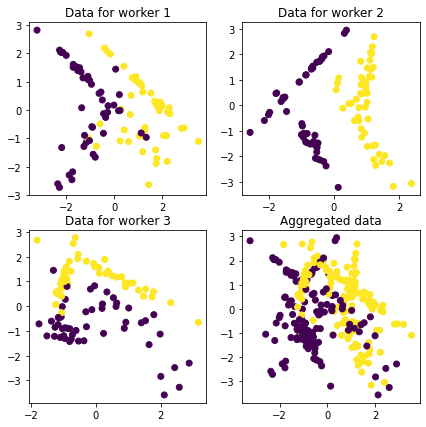

In [3]:
dim=2
classification = True
data, labels = create_data(n_samples, dim, n_workers, classification)
plot_3_classif(data, labels)

### Data 2: Linear Regression

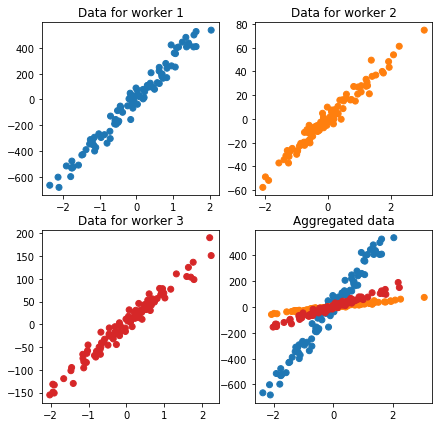

In [4]:
dim=1
classification = False
data, labels = create_data(n_samples, dim, n_workers, classification)
plot_3_reg(data, labels)

### Graphs 1: Fixed topology

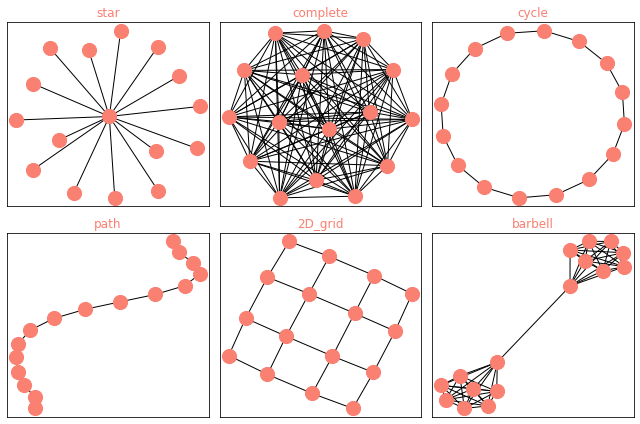

In [5]:
n_workers = 16
plot_all_fixed_graphs(n_workers)

### Graphs 2: Varying topology

We plot 2 sequences of 3 random geometric graphs (on which we forced the connectedness), with 2 different values of $\chi$ _( the $\chi$ displayed is the worst encountered in the sequence)_.\
In practice, we cycled through sequences of 50 graphs to simulate the time-varying setting, as done in [ADOM+](https://openreview.net/attachment?id=L8-54wkift&name=supplementary_material).

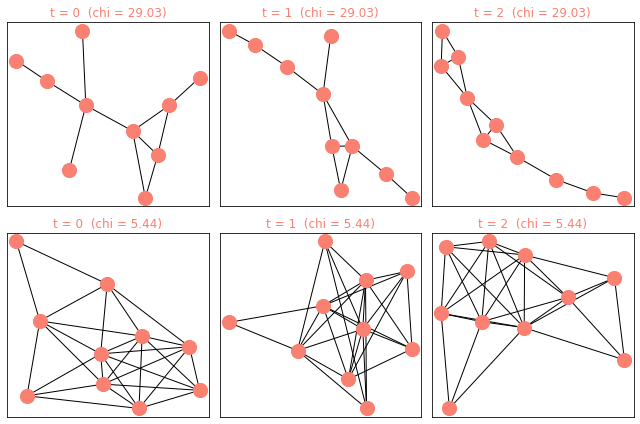

In [6]:
n_workers=10
plot_2_time_varying_graph_sequence(n_workers)

## Run the optimizers

#### Imports

In [7]:
import numpy as np
from main import main
from utils import compute_regularity_constants
from data import create_K_graphs, create_data
from visualization import print_communication_rates_fixed_topology, Args_for_main, plot_losses, plot_all_losses

#### Data and Graphs specification

In [8]:
# Variables for the graphs
n_workers = 300
radius = 0.15
id_graph_type = 0

list_graph_name = ['star', 'complete', 'cycle', 'path', '2D_grid', 'barbell', 'random_geom']
graph_type = list_graph_name[id_graph_type]
# create 50 graphs of the type considered
list_G, list_W, list_L_norm, chi_1_star, chi_2_star, chi_star = create_K_graphs(n_workers, graph_type, radius)
# display the several communication rates
print_communication_rates_fixed_topology(list_G, list_L_norm, chi_1_star, chi_2_star, chi_star, graph_type)

 Communication rates for the different methods on the star graph with 300 nodes. 
 We print the expected number of edges activated between two expected global rounds of gradient steps. 

 ADOM+ : 299 
 ADOM+ with Multi-Consensus : 62192 
 Continuized : 299 
 MSDA : 5083 
 DADAO : 299


In [9]:
# Variables for the datasets and task considered
n_samples=100*n_workers
dim=2
classification = False
data, labels = create_data(n_samples, dim, n_workers, classification)

# Regularity constants
mu, L = compute_regularity_constants(data, classification)
print(" Strong convexity coefficient : %.2f \n Smoothness coefficient : %.2f"%(mu,L))

 Strong convexity coefficient : 1.21 
 Smoothness coefficient : 3.01


In [10]:
# Initialize the arguments
args = Args_for_main(None, data, labels, classification, mu, L, dim, n_workers, chi_star, chi_1_star, chi_2_star, None, None, None, list_G, list_W, graph_type)

#### [DADAO](https://hal.archives-ouvertes.fr/hal-03737694/document)

In [11]:
args.optimizer_name = "DADAO"
args.t_max = 300
args.lamb_grad = n_workers
args.lamb_mix = np.sqrt(2*chi_1_star*chi_2_star)

In [12]:
opt_dadao, grad_loss_dadao, com_loss_dadao = main(args)

100%|█████████████████████████████████████████████████████████████████████████| 180376/180376 [05:25<00:00, 554.66it/s]


f_star sklearn :  26460.015407657273         |  f(x_bar) DADAO :  tensor(26460.0154, dtype=torch.float64)
x_star sklearn :  [129.27222121 128.88781786]  |  x_bar DADAO :  [129.27222244 128.88781866]


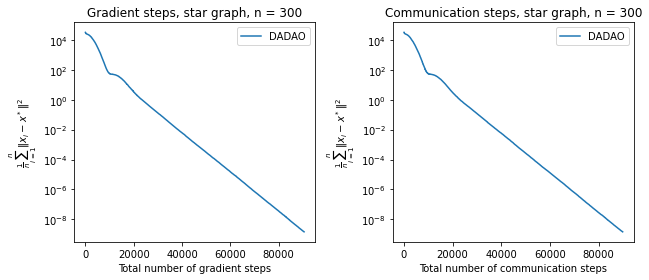

In [13]:
plot_losses(grad_loss_dadao, com_loss_dadao, 'DADAO', graph_type, n_workers)

#### [ADOM +](https://openreview.net/attachment?id=L8-54wkift&name=supplementary_material)

In [14]:
args.optimizer_name = "ADOMplus"
args.t_max = 300
args.use_multi_consensus = False

In [15]:
opt_adom, grad_loss_adom, com_loss_adom = main(args)

100%|███████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 280.03it/s]

f_star sklearn :  26460.015407657273         |  f(x_bar) ADOMplus :  tensor(52338.7103, dtype=torch.float64)
x_star sklearn :  [129.27222121 128.88781786]  |  x_bar ADOMplus :  [15.90607522 15.97482501]


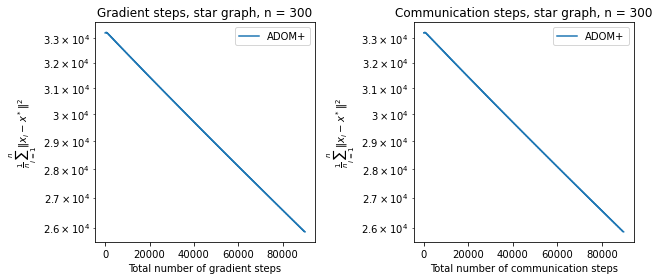

In [16]:
plot_losses(grad_loss_adom, com_loss_adom, 'ADOM+', graph_type, n_workers)

#### [ADOM + with Multi-Consensus]( https://openreview.net/attachment?id=L8-54wkift&name=supplementary_material )

In [17]:
args.optimizer_name = "ADOMplus"
args.t_max = 300
args.use_multi_consensus = True

In [18]:
opt_adom_mc, grad_loss_adom_mc, com_loss_adom_mc = main(args)

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [01:14<00:00,  4.02it/s]


f_star sklearn :  26460.015407657273         |  f(x_bar) ADOMplus :  tensor(26460.0154, dtype=torch.float64)
x_star sklearn :  [129.27222121 128.88781786]  |  x_bar ADOMplus :  [129.27219057 128.88786565]


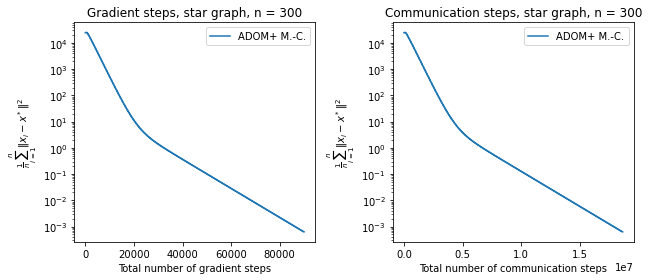

In [19]:
plot_losses(grad_loss_adom_mc, com_loss_adom_mc, 'ADOM+ M.-C.', graph_type, n_workers)

#### [MSDA](https://arxiv.org/pdf/1702.08704.pdf)

In [20]:
args.optimizer_name = "MSDA"
args.t_max = 300

In [21]:
opt_msda, grad_loss_msda, com_loss_msda = main(args)

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:23<00:00, 12.64it/s]


f_star sklearn :  26460.015407657273         |  f(x_bar) MSDA :  tensor(26460.0154, dtype=torch.float64)
x_star sklearn :  [129.27222121 128.88781786]  |  x_bar MSDA :  [129.27222121 128.88781786]


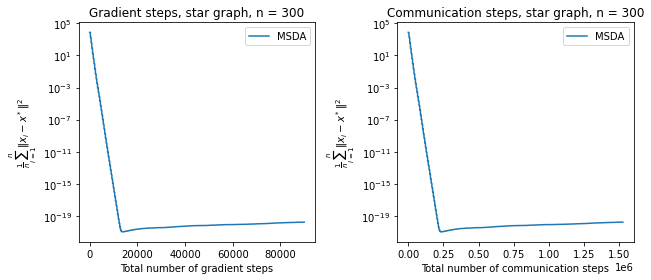

In [22]:
plot_losses(grad_loss_msda, com_loss_msda, 'MSDA', graph_type, n_workers)

#### [Continuized](https://arxiv.org/pdf/2106.07644.pdf)

In [23]:
args.optimizer_name = "Continuized"
args.t_max = 60000

In [24]:
opt_continuized, grad_loss_continuized, com_loss_continuized = main(args)

100%|████████████████████████████████████████████████████████████████████████████| 59625/59625 [49:26<00:00, 20.10it/s]


f_star sklearn :  26460.015407657273         |  f(x_bar) Continuized :  tensor(26460.0154, dtype=torch.float64)
x_star sklearn :  [129.27222121 128.88781786]  |  x_bar Continuized :  [129.27222121 128.88781786]


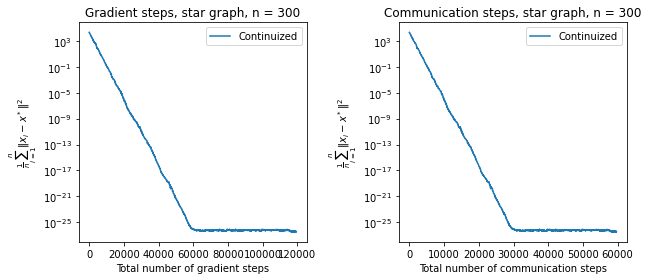

In [25]:
plot_losses(grad_loss_continuized, com_loss_continuized, 'Continuized', graph_type, n_workers)

#### Plot all the losses in the same figure

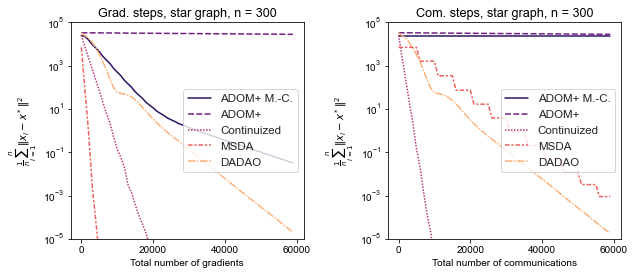

In [26]:
plot_all_losses(n_workers, grad_loss_dadao, com_loss_dadao, grad_loss_adom, com_loss_adom, grad_loss_adom_mc, com_loss_adom_mc,
                grad_loss_msda, com_loss_msda, grad_loss_continuized, com_loss_continuized, graph_type, id_max=6e4, compression=99.9)